# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 мая 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 мая, -4 балла после 06:00 13 мая, -6 баллов после 06:00 20 мая -8 баллов  после 06:00 27 мая


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [41]:
import re
import csv
import time
import codecs
import pandas as pd
import pylab as pl
import numpy as np
import pymorphy2
import scipy.spatial as ss
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\andre\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

\begin{equation*}
Вопрос\ 1
\end{equation*}

\begin{equation*}
Обозначения: \ Q\ -\ потери\ на\ шаге\ E,\ Q_r\ -\ потери\ после\ шага\ оптимизации\ по\ переменной\ r\   
\end{equation*}

\begin{equation*}
Функция\ потерь\ для\ элементов\ класса\ K\ с\ центром\ M_k\ будет:\
\end{equation*}

\begin{equation*}
Q_r = \sum_{x_i \in K} (||x_i - M_k||^2)
\end{equation*}

\begin{equation*}
(сумма\ минимумов\ равна\ минимуму\ суммы)
\end{equation*}

\begin{equation*}
Очевидно\ что\ минимум\ функции\ будет\ достигаться\ при\ M_k = \frac{\sum(x_i)}{N_k} \,\ где\ N_k\ -\ количество\ элементов\ в\ классе\ K.\ Последовательность\ значений\ функции\ Q\ является\ невозрастающей\ и\ ограниченной\ снизу\ 0.\ По\ теореме\ Вейерштрасса\ последовательность\ сходится.\
\end{equation*}

\begin{equation*}
Вопрос\ 2
\end{equation*}

\begin{equation*}
Существует\ k^n\ способов\ разделить\ n\ точек\ по\ k\ кластерам.\ Предположим\ значения\ функции\ потерь\ совпали\ на\ каких-либо\ двух\ итерациях\ оптимизации.\ Тогда,\ так\ как\ последовательность\ значений\ функции\ потерь\ является\ невозрастающей\ -\ все\ элементы\ последовательности\ расположенные\ между\ двумя\ совпадающими\ элементами\ так\ же\ будут\ совпадать.\ Получаем\ противоречие:\ если\ на\ двух\ подряд\ идущих\ итерациях\ алгоритма\ значения\ функции\ потерь\ совпали\ -\ алгоритм\ остановился,\ в\ то\ время\ как\ в\ построенной\ ситуации\ продолжил\ работу.
\end{equation*}

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

\begin{equation*} 
По\ аналогии,\ мы\ максимизируем\ функцию\ правдоподобия,\ максимизируя\ ее\ нижнюю\ оценку\ -\ L.\ На\ каждом\ шаге\ E\ и\ M\ -\ L\ не\ убывает\ и\ ограничена\ сверху\ 0,\ (т.к.\ вероятность\ ограничена\ сверху\ 1,\ а\ log\ 1\ =\ 0).\ В\ таком\ случае,\ по\ теореме\ Вейерштрасса\ и\ определнии\ предела\ функции\ по\ Гейне\ -\ функция\ сходится.
\end{equation*}

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

\begin{equation*} 
При\ объединении\ кластеров\ G\ и\ H,\ d(G,\ H) = d(a,\ b)\ ,\ где\ a \in G, b \in H
\end{equation*}
\begin{equation*} 
Тогда\ первая\ формула\ это\ по\ сути:\
\end{equation*}
\begin{equation*}
\min(d_{min}(U, S),d_{\min}(V, S))
\end{equation*}
\begin{equation*} 
Вторая\ по\ аналогии
\end{equation*}

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [42]:
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    def __init__(self, metric, linkage='single', n_clasters=2, **kwargs):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clasters = n_clasters
        self.linkage = linkage
        self.ind = 0
        self.dendenogram_info = np.array([])
        self.max_number_of_classes = 0
        
        if metric == 'euclidian':
            self.distance = self.__euclidian_distance
        elif metric == 'cosine':
            self.distance = self.__cosine_distance
        elif metric == 'words':
            self.distance = self.__words_distance
        elif metric == 'set':
            self.distance = self.__set_distance
        else:
            self.distance = self.__euclidian_distance
            
        if linkage == 'single':
            self.calculating_coefficients = self.__single_coefficients
        elif linkage == 'complete':
            self.calculating_coefficients = self.__complete_coefficients
        elif linkage == 'average':
            self.calculating_coefficients = self.__average_coefficients
        else:
            print("Error: Incorrect linkage name")
            self.calculating_coefficients = self.__single_coefficients
            
        pass
    
    def __euclidian_distance(self, a, b):
        a = np.array(a)
        b = np.array(b)
        return np.sqrt(np.sum((a - b) ** 2))

    def __cosine_distance(self, a, b):
        a = np.array(a)
        b = np.array(b)
        t = np.dot(a, b)
        p = sqrt((a ** 2).sum()) * sqrt((b ** 2).sum())
        if t / p > 1:
            return 0
        return np.arccos(t / p)

    def __words_distance(self, a, b):
        return 1 - len(Counter(a) & Counter(b)) / len(Counter(a) | Counter(b))
    
    def __set_distance(self, a, b):
        d = len(set.intersection(set(a), set(b)))
        if d == 0:
            return 2
        return 1 / d
    
    def update_tree(self, tree, pos_i, pos_j):
        self.max_number_of_classes += 1
        mas = np.zeros(len(tree))
        for i in range(len(tree)):
            mas[i] = tree[i]
            if tree[i] in [tree[int(pos_j)], tree[int(pos_i)]]:
                mas[i] = self.max_number_of_classes
        return mas
    
    def __single_coefficients(self, tree, x, y):
        return [1/2, 1/2, -1/2]
    
    def __complete_coefficients(self, tree, x, y):
        return [1/2, 1/2, 1/2] 
    
    def __average_coefficients(self, tree, x, y):
        c = [0, 0, 0]
        for i in tree:
                if i == tree[x]:
                    c[0] += 1
                if i == tree[y]:
                    c[1] += 1
        c[2] = c[0] + c[1]
        c[0] = c[0] / c[2]
        c[1] = c[1] / c[2]
        c[2] = 0
        return c
    
    def update_matrix(self, matrix_of_distances, tree, x, y):
        coefficient = [0, 0, 0]
        x = int(x)
        y = int(y)
        tree_x = np.array(matrix_of_distances[x])
        tree_y = np.array(matrix_of_distances[y])
        k = len(matrix_of_distances)
        coefficient = self.calculating_coefficients(tree, x, y)
        for i in range(k):
            if tree[i] in [tree[x], tree[y]]:
                for j in range(k):
                    tmp = coefficient[0] * tree_x[j] + coefficient[1] * tree_y[j] + coefficient[2] * abs(tree_x[j] - tree_y[j])
                    matrix_of_distances[i][j] = tmp
                    matrix_of_distances[j][i] = tmp
        return matrix_of_distances
    
    def search_minimum(self, matrix_of_distances, tree):
        k = len(matrix_of_distances)
        min_ = np.array([0, 0, -1])
        for i in range(k):
            for j in range(i + 1, k):
                if (min_[2] > matrix_of_distances[i][j] or min_[2] == -1) and tree[i] != tree[j]:
                    min_ = np.array([i, j, matrix_of_distances[i][j]])
        return min_
    
    def number_repr(self, tree, claster):
        number_repr = 0
        for i in tree:
            if i == claster:
                number_repr += 1
        return number_repr
    
    def build_tree(self, x):
        k = len(x)
        self.max_number_of_classes = k - 1
        tree = np.arange(0, k ** 2).reshape(k, k)
        
        matrix_of_distances = np.zeros((k, k))
        for i in range(k):
            for j in range(k):
                matrix_of_distances[i][j] = self.distance(x[i], x[j])
                matrix_of_distances[j][i] = matrix_of_distances[i][j]
                
        for i in range(1, k):
            minimum = self.search_minimum(matrix_of_distances, tree[i - 1])
            prev_x = tree[i - 1][int(minimum[0])]
            prev_y = tree[i - 1][int(minimum[1])]
            tree[i] = self.update_tree(tree[i - 1], minimum[0], minimum[1])
            matrix_of_distances = self.update_matrix(matrix_of_distances, tree[i - 1], minimum[0], minimum[1])
            minimum = np.append(minimum, self.number_repr(tree[i], tree[i][int(minimum[0])]))
            minimum[0] = prev_x
            minimum[1] = prev_y
            self.dendenogram_info = np.append(self.dendenogram_info, minimum)

        self.dendenogram_info = self.dendenogram_info.reshape(-1, 4)
        self.tree = tree
        return tree[k - self.n_clasters]
    
    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        return self.build_tree(x)
    
    def project_predict(self, border):
        for i in range(self.tree.shape[0]):
            mas = np.bincount(self.tree[i])
            if max(mas) >= border:
                cluster_index = mas.argmax()
                tree_pos = i
                break

        result = np.where(self.tree[i] == cluster_index)
        submission = np.zeros(len(X))
        submission[result] = 1
        return submission
    
    def cut_tree(self, height):
        i = 0
        while (i < len(self.dendenogram_info)) and (self.dendenogram_info[i][2] < height):
            i += 1
        return self.tree[i]
    
    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fig.set_figheight(10)
        fig.set_figwidth(20)
        hierarchy.dendrogram(self.dendenogram_info)
        pass

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

In [43]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

<Figure size 720x360 with 0 Axes>

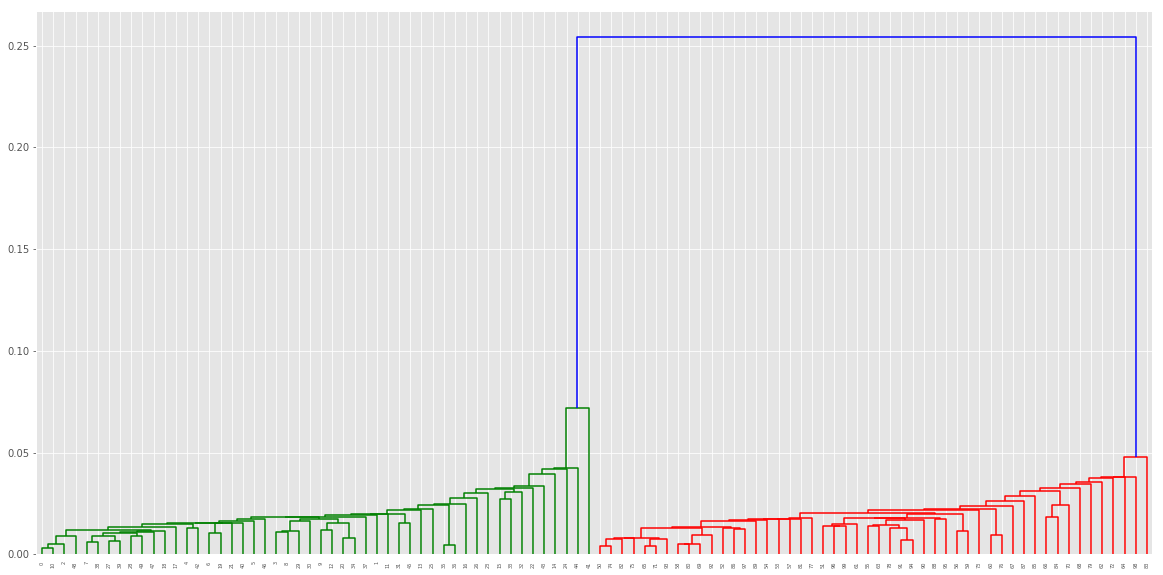

In [44]:
pl.figure(figsize=(10, 5))
myclf = Clustering('cosine', 'single', 2)
t = myclf.fit_predict(x_iris)
myclf.plot_dendrogram()
plt.show()

<Figure size 720x360 with 0 Axes>

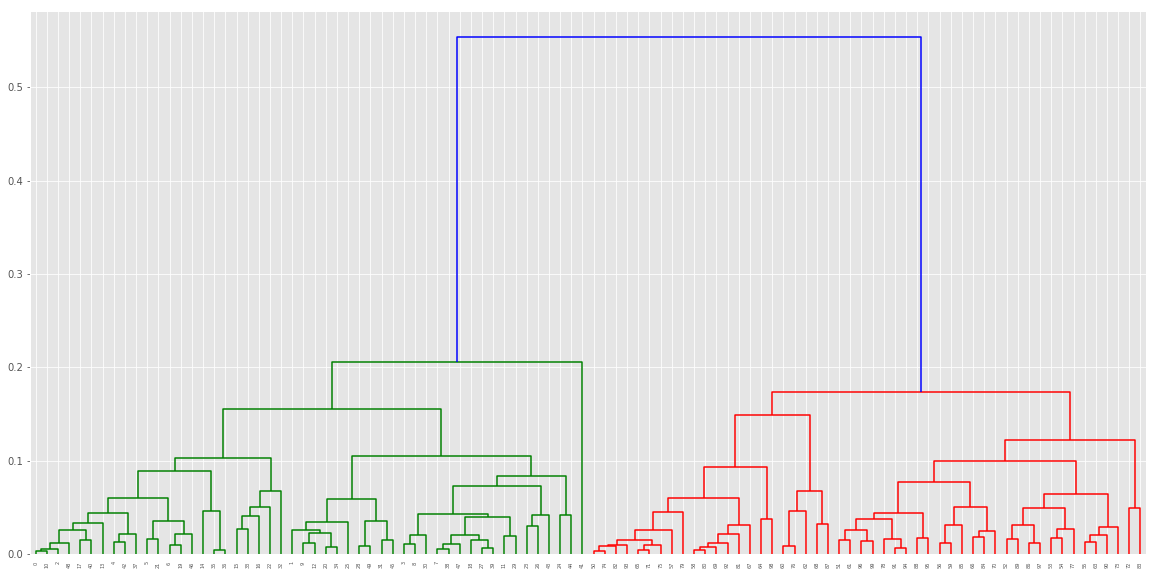

In [45]:
pl.figure(figsize=(10, 5))
myclf = Clustering('cosine', 'complete', 2)
t = myclf.fit_predict(x_iris)
t.shape
myclf.plot_dendrogram()
plt.show()

<Figure size 720x360 with 0 Axes>

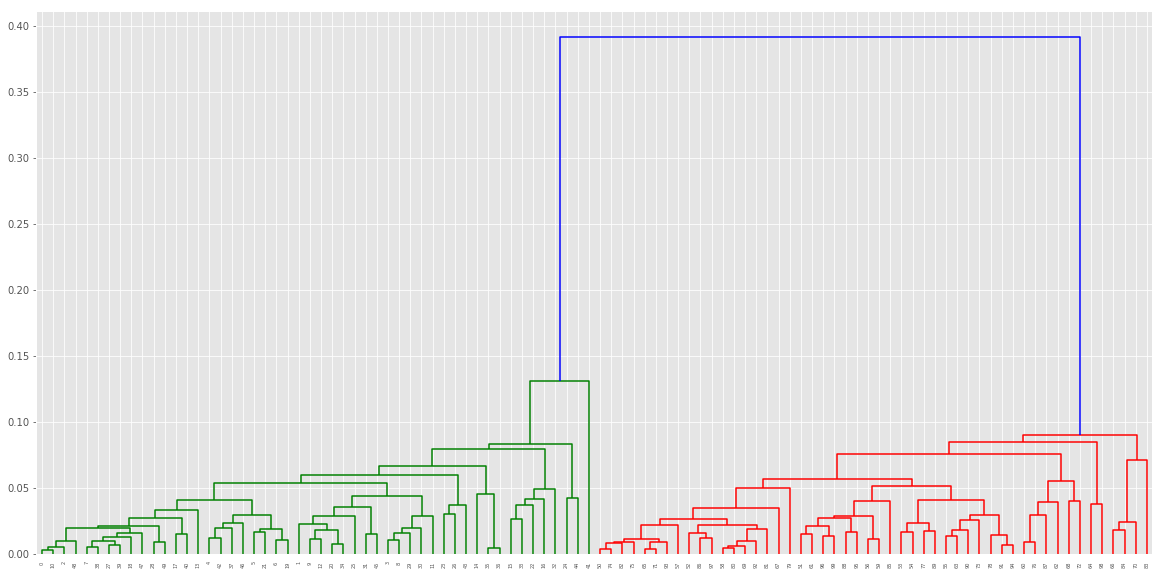

In [46]:
pl.figure(figsize=(10, 5))
myclf = Clustering('cosine', 'average', 2)
t = myclf.fit_predict(x_iris)
t.shape
myclf.plot_dendrogram()
plt.show()

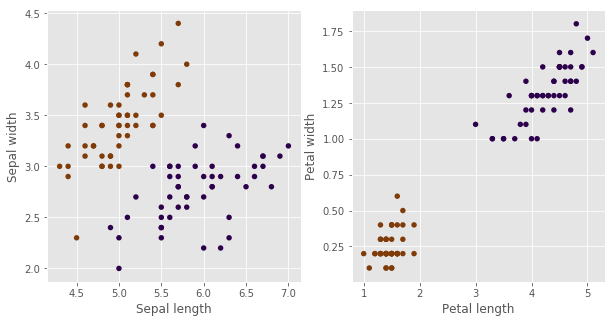

In [47]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [48]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.0059545040130615234


In [49]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='your_favourite_metric')
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.9422836303710938


# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? Как еще учесть другую информацию о странице в расстоянии?

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках. В семинаре мы рассматривали более сложный вариант, но Вы сможете придумать лучше. 

In [50]:
class Gibrid_Page_Group():
    
    def __init__(self, group_number, group='Train'):
        if group == 'Train':
            data = pd.read_csv('train_groups.csv')
            self.target_list = np.array(list(data[data.group_id == group_number]['target']))
        else:
            data = pd.read_csv('test_groups.csv')
        self.id_list = np.array(list(data[data.group_id == group_number]['doc_id']))
        pass
    
    def simple_norm(self, text):
        text = re.sub(r'[\n•0123456789.\\/\-,:?\"\'!()*=^–\|]', ' ', text)
        text = re.sub(r'(a-z)', '', text)
        reg = re.compile('[^а-яА-Я]')
        text = reg.sub(' ', text)
        while ('  ' in text):
            text = re.sub(r'  ', ' ', text)
        text = text.lower()
        return text
        
    def create_page_list(self):
        self.page_list = []
        
        for id_ in self.id_list:
            with codecs.open('data/' + str(id_) + '.dat', 'r', 'utf-8') as f:
                soup = BeautifulSoup(f.read())
                self.page_list.append(self.simple_norm(soup.text))
        pass

In [26]:
"""
проверка на score на train_groups
"""
train_data = pd.read_csv('train_groups.csv')
group_list = np.unique(np.array(list(train_data['group_id'])))

In [27]:
"""
выкачивание группы страниц
"""
check_result = np.zeros(0)
super_dict = {}
for group_id in group_list[:10]:
    group = Gibrid_Page_Group(group_id)
    group.create_page_list()
    super_dict[group_id] = group.page_list
    check_result = np.hstack((check_result, group.target_list))

In [34]:
result = np.zeros(0)
for group_id in group_list[:10]:
    
    print(group_id, end=' ')
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=100000, analyzer = 'char_wb',
                                 min_df=0.00, ngram_range=(5, 8), norm='l1')
    X = vectorizer.fit_transform(super_dict[group_id]).toarray()
    
    mas = []
    arr = np.zeros(len(X))

    for j in range(len(X)):
        arr = np.dot(X, X[j])
        mas.append(np.argsort(arr)[-20:])
    mas = np.array(mas)
    myclf = Clustering('set', 'average', 2)
    myclf.fit_predict(mas)
    result = np.hstack((result, myclf.project_predict(border=20))) 
    

1 2 3 4 5 6 7 8 9 10 

In [35]:
smt.f1_score(check_result, result, average='macro')

0.5373370815231281

In [4]:
train_data = pd.read_csv('test_groups.csv')
group_list = np.unique(np.array(list(train_data['group_id'])))

In [5]:
"""
выкачивание группы страниц
"""
check_result = np.zeros(0)
super_dict = {}
for group_id in group_list:
    print(group_id, end=' ')
    group = Gibrid_Page_Group(group_id, group='Test')
    group.create_page_list()
    super_dict[group_id] = group.page_list

130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 

In [21]:
result = np.zeros(0)
for group_id in group_list:
    
    print(group_id, end=' ')
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=50000, analyzer = 'char_wb',
                                 min_df=0.00, ngram_range=(5, 8), norm='l1')
    X = vectorizer.fit_transform(super_dict[group_id]).toarray()
    
    mas = []
    arr = np.zeros(len(X))

    for j in range(len(X)):
        arr = np.dot(X, X[j])
        mas.append(np.argsort(arr)[-20:])
    mas = np.array(mas)
    myclf = Clustering('set', 'average', 2)
    myclf.fit_predict(mas)
    result = np.hstack((result, myclf.project_predict(border=20))) 

130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 

In [22]:
len(np.where(result == 1)[0]), len(result)

(4055, 16627)

In [23]:
res = list(map(int, result))

In [24]:
with open('sample_submission.csv', 'w') as f:
    fieldnames = ['pair_id', 'target']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    i = 11691
    for elem in res:
        writer.writerow({'pair_id': str(i), 'target': str(elem)})
        i += 1
f.close()

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять например словами из тайтла

Главное подобрать хорошую функцию расстояния между документами

Удачи! Все получится!

Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [11]:
# Место для Вашего кластерного анализа


Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***
1. задачи кластеризации для поиска явно разделимых классов,
2. для совместного использования с другими моделями и получения новых фичей

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***

kmeans 

Недостатки: не даёт ответа на то какой из кластеров принадлежит какому классу, чувствителен к выбросам

Преимущества: работает на известном числе кластеров, чувствителен к выбросам



Агломеративная кластеризация 

Преимущества: даёт представление о плотности объектов в кластере (хорошо работает при анализе выбросов)

Недостатки: не работает при неизвестном количестве кластеров, нельзя добавлять train и test в уже построенную модель



dbscan

Преимущества: хорошо ищет выбросы, сам определяет число кластеров

Недостатки: плохо работает при необходимости кластеризовать данные с сильно колеблющейся плотностью, нельзя дообучать

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***

мне пока не доводилось проходить курс математической статистики, но я предполагаю, что 
если рассматривать оценку максимального правдоподобия как достижения максимума в некотором распределении,
то при наожении нескольких распределений (т.е. наличии нескольких локальных максимумов)
эта оценка может не давать требуемого результата

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***

я бы реализовывал алгоритм, который применил выше:

сначала представил документы через tf_idf

потом представлял бы документы как множества из k номеров ближайжих текстов (например расстояние = 1 / скалярное произведение)

как показала практика (у меня во всяком случае) этот алгоритм лучше всего находит близкие по тематике документы

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***

разумеется

размеченная часть подошла бы для поиска выбросов в неразмеченной части с помощью кластеризации 

так же результаты кластеризации (например номера ближайших кластеров и расстояние до их центров) 
можно было бы использовать как дополнительные фичи в следующих моделях

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

интересное дз, но мне кажется что kmeans реализовывать было бы интереснее (лично мне)

*** ВАШ ОТЗЫВ ЗДЕСЬ***